Accessing https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2020/047/027/LC08_L2SP_047027_20201204_20210313_02_T1/LC08_L2SP_047027_20201204_20210313_02_T1_SR_B2.TIF
(250, 246)


,Array,Chunk
Bytes,129.33 GiB,8.00 MiB
Shape,"(8, 22, 7972, 12372)","(1, 1, 1024, 1024)"
Count,18656 Tasks,18304 Chunks
Type,float64,numpy.ndarray


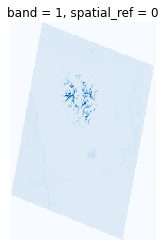

In [2]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

from pystac_client import Client

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

#%%
time_range = "2020-12-01/2020-12-31"
bbox = [-122.2751, 47.5469, -121.9613, 47.7458]

search = catalog.search(collections=["landsat-c2-l2"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

#%%
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.2751, 47.5469],
            [-121.9613, 47.9613],
            [-121.9613, 47.9613],
            [-122.2751, 47.9613],
            [-122.2751, 47.5469],
        ]
    ],
}

time_range = "2020-12-01/2020-12-31"

search = catalog.search(
    collections=["landsat-c2-l2"], intersects=area_of_interest, datetime=time_range
)

#%%
import geopandas

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df.plot()

#%%
selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
selected_item

#%%
import rich.table

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in selected_item.assets.items():
    # print(f"{asset_key:<25} - {asset.title}")
    table.add_row(asset_key, asset.title)

table

#%%
selected_item.assets["rendered_preview"].to_dict()

from IPython.display import Image

Image(url=selected_item.assets["rendered_preview"].href, width=500)

#%%
import requests

url = selected_item.assets["blue"].href
print("Accessing", url)
response = requests.get(url)
response

#%%
import planetary_computer

# PC_SDK_SUBSCRIPTION_KEY
signed_href = planetary_computer.sign(selected_item).assets["blue"].href

#%%
import xarray as xr
import rioxarray

ds = rioxarray.open_rasterio(signed_href, overview_level=4).squeeze()
img = ds.plot(cmap="Blues", add_colorbar=False)
img.axes.set_axis_off();
print(ds.data.shape)

#%%
import pystac
import planetary_computer
import rioxarray

item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220813T104629_R051_T31UGU_20220813T220324"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)
signed_item = planetary_computer.sign(item)

# Open one of the data assets (other asset keys to use: 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual')
asset_href = signed_item.assets["B04"].href
ds = rioxarray.open_rasterio(asset_href)

#%%
import stackstac

ds = stackstac.stack(planetary_computer.sign(items))
ds

#%%


In [3]:
stackstac.show(ds)

ValueError: No global client found and no address provided